In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from IPython.display import Image
import shutil
import os
from random import choice

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
IMAGE_SIZE = [299, 299]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in inception.layers:
    layer.trainable = False
x = Flatten()(inception.output)
prediction = Dense(15, activation='softmax')(x)

# create a model object
inceptionv3 = Model(inputs=inception.input, outputs=prediction)
inceptionv3.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [ ]:
inceptionv3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory("/content/drive/MyDrive/Dataset/train",
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory("/content/drive/MyDrive/Dataset/test",
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')



r = inceptionv3.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Found 1388 images belonging to 15 classes.
Found 423 images belonging to 15 classes.
Epoch 1/50
44/44 [==============================] - 1416s 32s/step - loss: 28.6710 - accuracy: 0.3329 - val_loss: 14.4041 - val_accuracy: 0.4137
Epoch 2/50
44/44 [==============================] - 128s 3s/step - loss: 5.1206 - accuracy: 0.6873 - val_loss: 6.8739 - val_accuracy: 0.5934
Epoch 3/50
44/44 [==============================] - 125s 3s/step - loss: 2.8573 - accuracy: 0.7767 - val_loss: 5.2863 - val_accuracy: 0.6950
Epoch 4/50
44/44 [==============================] - 130s 3s/step - loss: 2.3979 - accuracy: 0.8033 - val_loss: 5.9280 - val_accuracy: 0.6478
Epoch 5/50
44/44 [==============================] - 126s 3s/step - loss: 2.5261 - accuracy: 0.8134 - val_loss: 6.1076 - val_accuracy: 0.6903
Epoch 6/50
44/44 [==============================] - 129s 3s/step - loss: 2.1820 - accuracy: 0.8444 - val_loss: 6.8614 - val_accuracy: 0.6927
Epoch 7/50
44/44 [==============================] - 122s 3s/step 

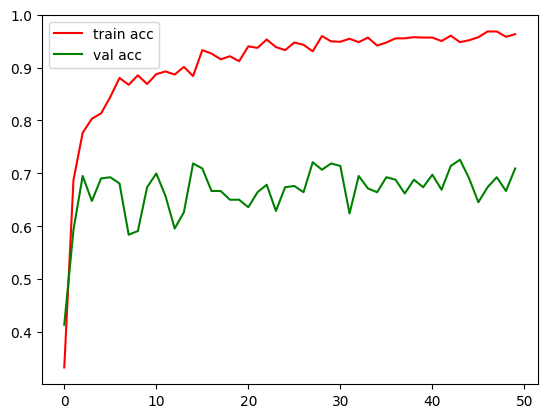

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(r.history['accuracy'], label='train acc',color='red')
plt.plot(r.history['val_accuracy'], label='val acc',color='green')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
inceptionv3.save('my_model_incep.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

res = {0:"CarpetWeeds",1:"Crabgrass",2:"Eclipta",3:"Goosegrass",4:"Morningglory",5:"Nutsedge",6:"PalmerAmaranth",7:"Prickly Sida",8:"Purslane",9:"Ragweed",10:"Sicklepod",11:"SpottedSpurge",12:"SpurredAnoda",13:"Swinecress",14:"Waterhemp"}
def model_predict(img_path, model):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = x / 255.0  # Normalize pixel values
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    predicted_class_index = np.argmax(preds, axis=1)[0]
    return predicted_class_index

img_path = '/content/drive/MyDrive/Dataset/test/Waterhemp/IMG_1036.JPG'
predicted_class_index = model_predict(img_path, inceptionv3)
print(res[predicted_class_index])

1/1 [==============================] - 0s 30ms/step
Waterhemp


----------------------------Resnet-------------------------------------------------------------------------------------------------------------

In [ ]:
img_h = 299
img_w = 299
img_height = 299
img_width = 299
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from zipfile import ZipFile
from matplotlib import pyplot as plt
num_classes = 15  # Adjust according to your dataset

# Data augmentation and preprocessing for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Data augmentation and preprocessing for test set
test_datagen = ImageDataGenerator(rescale=1./255)

test = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/test',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale = 1/255.,
#     horizontal_flip = True,
#     vertical_flip = True,
#     validation_split = 0.2
# )

# train = datagen.flow_from_directory(
#     '/content/drive/MyDrive/Dataset/train',
#     class_mode='categorical',
#     subset = 'training',
#     target_size = (img_h, img_w),
#     batch_size = 32
# )

# valid = datagen.flow_from_directory(
#     '/content/drive/MyDrive/Dataset/test',
#     class_mode='categorical',
#     subset = 'validation',
#     target_size = (img_h, img_w),
#     batch_size = 32
# )

Found 1388 images belonging to 15 classes.
Found 423 images belonging to 15 classes.


----check

In [ ]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

In [ ]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

# Define the input layer with the correct shape
in_layer = tf.keras.layers.Input(shape=(224, 224, 3))

# Load the pre-trained ResNet152V2 model
resnet = ResNet152V2(include_top=False, weights='imagenet', input_tensor=in_layer)

# Freeze all layers in the base model
for layer in resnet.layers:
    layer.trainable = False

# Add your custom classification layers
inter = tf.keras.layers.GlobalMaxPooling2D()(resnet.output)
flatten = tf.keras.layers.Flatten()(inter)
output = tf.keras.layers.Dense(15, activation='softmax')(flatten)

# Create the final model
resnet_final = tf.keras.models.Model(inputs=in_layer, outputs=output)


In [ ]:
model = resnet


In [ ]:
initial_lr = 0.01


lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=25,
    decay_rate=0.96,
    staircase=True
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=10, verbose=0)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.hdf5', monitor='val_acc', mode='max', save_weights_only=True, verbose=0)

callbacks = [checkpoint, early_stopping]

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
loss_funct = 'CategoricalCrossentropy'

model.compile(optimizer=optim, loss=loss_funct, metrics=['acc',f1_m,precision_m, recall_m])

In [ ]:
model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(train, validation_data=valid, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

In [ ]:
tf.keras.models.save_model(model,'model_resnet.hdf5')

In [ ]:
model.save('resnet152v2.h5')

In [ ]:
x_axis = range(epochs)

plt.plot(history.epoch, history.history['acc'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_acc'], label='Validation Accuracy')
plt.legend()


In [ ]:
----final resnet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset
train_path = '/content/drive/MyDrive/Dataset/train'
test_path = '/content/drive/MyDrive/Dataset/test'

# Define image dimensions and number of classes
img_height, img_width = 224, 224
num_classes = 15  # Adjust according to your dataset

# Data augmentation and preprocessing for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Data augmentation and preprocessing for test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Load pre-trained ResNet152V2 model without top (fully connected layers)
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(15, activation='softmax')(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model



Found 1388 images belonging to 15 classes.
Found 423 images belonging to 15 classes.
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_13[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
       

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


history = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=50,
    validation_data=test_set,
    validation_steps=len(test_set),

)


Epoch 1/50
44/44 [==============================] - 121s 3s/step - loss: 2.6579 - accuracy: 0.1477 - val_loss: 2.5934 - val_accuracy: 0.2128
Epoch 2/50
44/44 [==============================] - 115s 3s/step - loss: 2.5636 - accuracy: 0.2817 - val_loss: 2.5225 - val_accuracy: 0.3239
Epoch 3/50
44/44 [==============================] - 115s 3s/step - loss: 2.4917 - accuracy: 0.3732 - val_loss: 2.4613 - val_accuracy: 0.3948
Epoch 4/50
44/44 [==============================] - 114s 3s/step - loss: 2.4359 - accuracy: 0.4121 - val_loss: 2.4179 - val_accuracy: 0.4208
Epoch 5/50
44/44 [==============================] - 115s 3s/step - loss: 2.3795 - accuracy: 0.4503 - val_loss: 2.3764 - val_accuracy: 0.4208
Epoch 6/50
44/44 [==============================] - 111s 3s/step - loss: 2.3385 - accuracy: 0.4683 - val_loss: 2.3196 - val_accuracy: 0.4563
Epoch 7/50
44/44 [==============================] - 116s 3s/step - loss: 2.2873 - accuracy: 0.4914 - val_loss: 2.2793 - val_accuracy: 0.4728
Epoch 8/50
44

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

-----------------------------------yolov5-----------------------------

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()



KeyboardInterrupt: 

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
! kaggle competitions download -c 'name-of-competition'

In [ ]:
! mkdir yolov8
! unzip train.zip -d yolov8

---------RESNET+INCEPTION-V3----------------------------

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, ResNet152V2
from tensorflow.keras.layers import Concatenate, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the path to your dataset
train_path = '/content/drive/MyDrive/Dataset/train'
test_path = '/content/drive/MyDrive/Dataset/test'

# Define image dimensions and number of classes
img_height, img_width = 224, 224
num_classes = 15  # Adjust according to your dataset

# Data augmentation and preprocessing for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Data augmentation and preprocessing for test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Define input layer
input_layer = Input(shape=(img_height, img_width, 3))

# Build InceptionV3 branch
inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_layer)
inception_output = GlobalAveragePooling2D()(inception_base.output)

# Build ResNet152V2 branch
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_tensor=input_layer)
resnet_output = GlobalAveragePooling2D()(resnet_base.output)

# Concatenate features from both branches
concatenated_features = Concatenate()([inception_output, resnet_output])

# Additional classification layers
# Additional classification layer
output = Dense(num_classes, activation='softmax')(concatenated_features)

# Create the final model
model = Model(inputs=input_layer, outputs=output)

# Define precision, recall, and F1-score metrics
import tensorflow as tf

from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Compile the model with precision, recall, and F1-score metrics
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

# Print model summary
model.summary()

# Train the model



Found 1388 images belonging to 15 classes.
Found 423 images belonging to 15 classes.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
       

In [ ]:
history = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=30,  # Adjust as needed
    validation_data=test_set,
    validation_steps=len(test_set)
)

Epoch 1/30
44/44 [==============================] - 1378s 28s/step - loss: 1.7804 - accuracy: 0.4568 - precision_m: 0.6199 - recall_m: 0.2850 - f1_m: 0.3825 - val_loss: 13995312414720.0000 - val_accuracy: 0.0709 - val_precision_m: 0.0749 - val_recall_m: 0.0749 - val_f1_m: 0.0749
Epoch 2/30
44/44 [==============================] - 123s 3s/step - loss: 1.1242 - accuracy: 0.6628 - precision_m: 0.7673 - recall_m: 0.5353 - f1_m: 0.6274 - val_loss: 866707.1250 - val_accuracy: 0.0851 - val_precision_m: 0.0804 - val_recall_m: 0.0804 - val_f1_m: 0.0804
Epoch 3/30
44/44 [==============================] - 121s 3s/step - loss: 0.8156 - accuracy: 0.7406 - precision_m: 0.8185 - recall_m: 0.6570 - f1_m: 0.7275 - val_loss: 2849.2686 - val_accuracy: 0.0709 - val_precision_m: 0.0670 - val_recall_m: 0.0670 - val_f1_m: 0.0670
Epoch 4/30
44/44 [==============================] - 123s 3s/step - loss: 0.6778 - accuracy: 0.7817 - precision_m: 0.8437 - recall_m: 0.7079 - f1_m: 0.7688 - val_loss: 20.6559 - val_a

In [ ]:
model.save('combination.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

dl_prec = history.history["precision_m"][-1]
dl_rec = history.history["recall_m"][-1]
dl_f1 = history.history["f1_m"][-1]


In [ ]:
print(dl_f1 ,dl_rec,dl_prec)

0.9642547369003296 0.9562025666236877 0.9726661443710327


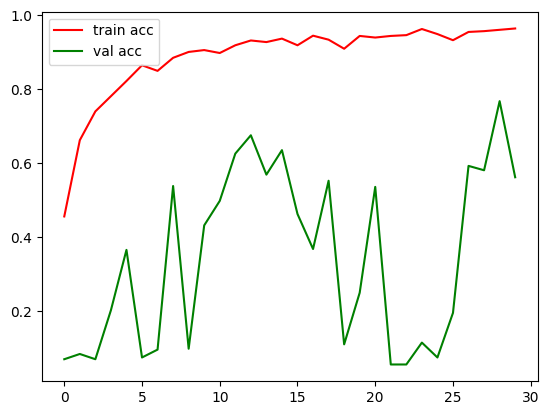

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc',color='red')
plt.plot(history.history['val_accuracy'], label='val acc',color='green')
plt.legend()
plt.show()
plt.savefig('combination_accu')

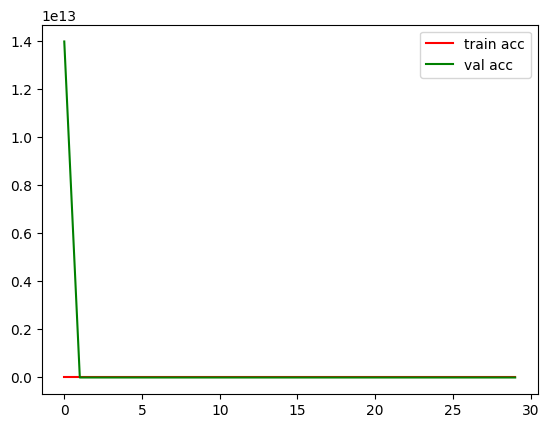

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train acc',color='red')
plt.plot(history.history['val_loss'], label='val acc',color='green')
plt.legend()
plt.show()
plt.savefig('combination_accu_loss')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

res = {0:"CarpetWeeds",1:"Crabgrass",2:"Eclipta",3:"Goosegrass",4:"Morningglory",5:"Nutsedge",6:"PalmerAmaranth",7:"Prickly Sida",8:"Purslane",9:"Ragweed",10:"Sicklepod",11:"SpottedSpurge",12:"SpurredAnoda",13:"Swinecress",14:"Waterhemp"}
def model_predict(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = x / 255.0  # Normalize pixel values
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    predicted_class_index = np.argmax(preds, axis=1)[0]
    return predicted_class_index

img_path = '/content/drive/MyDrive/Dataset/test/Purslane/IMG_1415.JPG'
predicted_class_index = model_predict(img_path, model)
print(res[predicted_class_index])

1/1 [==============================] - 0s 43ms/step
Purslane


Detection-----------------

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 13.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")

results = model.train(data="/content/drive/MyDrive/Dataset/yolov8/data (1).yaml", epochs=10, imgsz=416)

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Dataset/yolov8/data (1).yaml, epochs=10, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

100%|██████████| 755k/755k [00:00<00:00, 82.7MB/s]


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/drive/MyDrive/Dataset/yolov8/cotton_weed/train/labels.cache... 12249 images, 1 backgrounds, 0 corrupt: 100%|██████████| 12250/12250 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Dataset/yolov8/cotton_weed/valid/labels.cache... 1342 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1342/1342 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G     0.6386      2.222     0.9945         11        416: 100%|██████████| 766/766 [3:14:03<00:00, 15.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [15:41<00:00, 22.43s/it]

                   all       1342       2004      0.619      0.627       0.67      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.5191      1.312     0.9134         15        416: 100%|██████████| 766/766 [1:22:00<00:00,  6.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [03:02<00:00,  4.35s/it]

                   all       1342       2004      0.673      0.688      0.738      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.5043      1.052     0.9022         18        416: 100%|██████████| 766/766 [1:21:39<00:00,  6.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [03:05<00:00,  4.42s/it]

                   all       1342       2004      0.823       0.68      0.772      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.4651     0.8834     0.8904         16        416: 100%|██████████| 766/766 [1:23:17<00:00,  6.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [03:15<00:00,  4.65s/it]

                   all       1342       2004      0.834      0.763      0.841      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.4327     0.7502     0.8776         16        416: 100%|██████████| 766/766 [1:23:02<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [03:09<00:00,  4.51s/it]

                   all       1342       2004       0.81      0.823      0.871      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.4123     0.6652     0.8714         14        416: 100%|██████████| 766/766 [1:21:44<00:00,  6.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [03:11<00:00,  4.56s/it]

                   all       1342       2004      0.845      0.827      0.882      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.3881     0.6005     0.8588         15        416: 100%|██████████| 766/766 [1:23:01<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [03:08<00:00,  4.48s/it]

                   all       1342       2004      0.842      0.852       0.89      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.3656      0.533     0.8495         13        416: 100%|██████████| 766/766 [1:22:06<00:00,  6.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [02:56<00:00,  4.20s/it]

                   all       1342       2004      0.885      0.842      0.921      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.3485     0.4869     0.8441         16        416: 100%|██████████| 766/766 [1:18:20<00:00,  6.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [02:53<00:00,  4.13s/it]

                   all       1342       2004      0.906      0.839      0.923      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.3305     0.4437      0.837         12        416: 100%|██████████| 766/766 [1:15:09<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [02:53<00:00,  4.12s/it]

                   all       1342       2004      0.907      0.847      0.931      0.891



10 epochs completed in 16.135 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3007988 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [02:38<00:00,  3.77s/it]


                   all       1342       2004      0.867      0.884       0.93       0.89
             Waterhemp       1342        501      0.867      0.922      0.957      0.914
          MorningGlory       1342        280      0.935      0.943      0.966      0.915
              Purslane       1342        264      0.904      0.886      0.959      0.901
         SpottedSpurge       1342         93      0.853      0.925      0.961      0.924
            Carpetweed       1342        158      0.854      0.813      0.883      0.836
               Ragweed       1342        179      0.914      0.893      0.945      0.893
               Eclipta       1342        244       0.93      0.931      0.971      0.925
           PricklySida       1342         95      0.782      0.895      0.905      0.868
        PalmerAmaranth       1342         63      0.904      0.895      0.961      0.938
             Sicklepod       1342         58      0.893      0.983      0.978      0.965
            Goosegras

In [ ]:
import os
import numpy as np
from torch.utils.data import Dataset

class WeedDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        # Define two classes
        self.add_class("dataset", 1, "crop")
        self.add_class("dataset", 2, "weed")

        # Define data locations
        images_dir = '/content/drive/MyDrive/Dataset/yolov8/cotton_weed/train/images/'
        annotations_dir = '/content/drive/MyDrive/Dataset/yolov8/cotton_weed/train/labels/'

        # Find all images
        for filename in os.listdir(images_dir):
            # Extract image id
            image_id = filename[:-4]
            # Skip bad images
            if (image_id == '.ipynb_checkpo'):
                continue
            # Skip all images after 115 if we are building the train set
            if is_train and int(image_id) >= 32279:
                continue
            # Skip all images before 115 if we are building the test/val set
            if not is_train and int(image_id) < 32279:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.txt'
            # Add to dataset
            with open(ann_path, 'r') as file:
                annotations = file.readlines()
                # Extract class_ids from annotations
                class_ids = [int(line.split()[0]) for line in annotations]
                self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids=class_ids)

    def extract_boxes(self, filename):
        # Load and parse the file
        with open(filename, 'r') as file:
            lines = file.readlines()

        # Extract each bounding box
        boxes = []
        for line in lines:
            # Split the line and extract box coordinates
            values = line.strip().split()
            name = values[0]  # Assuming the class name is in the first column
            xmin, ymin, xmax, ymax = map(int, values[1:])  # Assuming the box coordinates follow the class name
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)

        # Extract image dimensions (assuming they are not in the annotation file)
        width = height = None  # You may need to obtain image dimensions from another source
        return boxes, width, height

    def load_mask(self, image_id):
        # Get details of the image
        info = self.image_info[image_id]
        # Define the path to the annotation file
        path = info['annotation']
        # Load boxes and image dimensions from the .txt file
        boxes, w, h = self.extract_boxes(path)
        # Create one array for all masks, each on a different channel
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        # Create masks
        class_ids = []
        for i, box in enumerate(boxes):
            row_s, row_e, col_s, col_e, class_name = box
            row_s, row_e, col_s, col_e = int(row_s), int(row_e), int(col_s), int(col_e)
            if class_name == 'crop':
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('crop'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('weed'))
        return masks, np.asarray(class_ids, dtype='int32')


In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import pdb
import numpy as np
import skimage

#pdb.set_trace()

# class that defines and loads the weed dataset
class WeedDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
    # Define two classes
    self.add_class("dataset", 1, "crop")
    self.add_class("dataset", 2, "weed")

    # Define data locations
    images_dir = '/content/drive/MyDrive/Dataset/yolov8/cotton_weed/train/images/'
    annotations_dir = '/content/drive/MyDrive/Dataset/yolov8/cotton_weed/train/labels/'

    # Find all images
    for filename in os.listdir(images_dir):
        # Extract image id
        image_id = filename[:-4]
        # Skip bad images
        if (image_id == '.ipynb_checkpo'):
            continue
        # Skip all images after 115 if we are building the train set
        if is_train and int(image_id) >= 32279:
            continue
        # Skip all images before 115 if we are building the test/val set
        if not is_train and int(image_id) < 32279:
            continue
        img_path = images_dir + filename
        ann_path = annotations_dir + image_id + '.txt'
        # Add to dataset
        with open(ann_path, 'r') as file:
            annotations = file.readlines()
            # Extract class_ids from annotations
            class_ids = [int(line.split()[0]) for line in annotations]
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids=class_ids)


	# extract bounding boxes from an annotation file
   def extract_boxes(self, filename):
    # Load and parse the file
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Extract each bounding box
    boxes = []
    for line in lines:
        # Split the line and extract box coordinates
        values = line.strip().split()
        name = values[0]  # Assuming the class name is in the first column
        xmin, ymin, xmax, ymax = map(int, values[1:])  # Assuming the box coordinates follow the class name
        coors = [xmin, ymin, xmax, ymax, name]
        boxes.append(coors)

    # Extract image dimensions (assuming they are not in the annotation file)
    width = height = None  # You may need to obtain image dimensions from another source
    return boxes, width, height


	# load the masks for an image
	 def load_mask(self, image_id):
    # Get details of the image
    info = self.image_info[image_id]
    # Define the path to the annotation file
    path = info['annotation']
    # Load boxes and image dimensions from the .txt file
    boxes, w, h = self.extract_boxes(path)
    # Create one array for all masks, each on a different channel
    masks = np.zeros([h, w, len(boxes)], dtype='uint8')
    # Create masks
    class_ids = []
    for i, box in enumerate(boxes):
        row_s, row_e, col_s, col_e, class_name = box
        row_s, row_e, col_s, col_e = int(row_s), int(row_e), int(col_s), int(col_e)
        if class_name == 'crop':
            masks[row_s:row_e, col_s:col_e, i] = 2
            class_ids.append(self.class_names.index('crop'))
        else:
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('weed'))
    return masks, np.asarray(class_ids, dtype='int32')



	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# define a configuration for the model
class WeedConfig(Config):
	# define the name of the configuration
	NAME = "weed_cfg"
	# number of classes (background + weed + crop)
	NUM_CLASSES = 1 + 2
	# number of training steps per epoch
	STEPS_PER_EPOCH = 160




IndentationError: unindent does not match any outer indentation level (<tokenize>, line 19)

In [ ]:
# prepare train set
train_set = WeedDataset()
train_set.load_dataset('Ronin_OPEN_DB', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = WeedDataset()
test_set.load_dataset('Ronin_OPEN_DB', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = WeedConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')

AttributeError: 'WeedDataset' object has no attribute 'add_class'

In [ ]:
!pip install mrcnn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54909 sha256=a61afdd52f4b7462dc3ca018e42859ea290a742455e38b9ef9b91db2398171ab
  Stored in directory: /root/.cache/pip/wheels/f6/66/35/4956a489776a1db0ee24e0c33a9088c1b5d68eb5dc2654f0b2
Successfully built mrcnn


In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import numpy as np
import os

# Class that defines and loads the weed dataset
class WeedDataset(Dataset):
    # Load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # Define two classes
        self.add_class("dataset", 1, "crop")
        self.add_class("dataset", 2, "weed")

        # Define data locations
        images_dir = '/content/drive/MyDrive/Dataset/yolov8/cotton_weed/train/images/'
        annotations_dir = '/content/drive/MyDrive/Dataset/yolov8/cotton_weed/train/labels/'

        if not is_train:
            images_dir = os.path.join(dataset_dir, "test", "images")
            annotations_dir = os.path.join(dataset_dir, "test", "labels")

        # Find all images
        for filename in listdir(images_dir):
            # Extract image id
            image_id = filename[:-4]
            img_path = os.path.join(images_dir, filename)
            ann_path = os.path.join(annotations_dir, image_id + '.txt')

            # Add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids=[0, 1, 2])

    # Extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # Load and parse the file
        with open(filename, 'r') as file:
            lines = file.readlines()

        # Extract each bounding box
        boxes = []
        for line in lines:
            # Split the line and extract box coordinates
            values = line.strip().split()
            name = values[0]  # Assuming the class name is in the first column
            xmin, ymin, xmax, ymax = map(int, values[1:])  # Assuming the box coordinates follow the class name
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)

        # Extract image dimensions (assuming they are not in the annotation file)
        width = height = None  # You may need to obtain image dimensions from another source
        return boxes, width, height

    # Load the masks for an image
    def load_mask(self, image_id):
        # Get details of the image
        info = self.image_info[image_id]
        # Define the path to the annotation file
        path = info['annotation']
        # Load boxes and image dimensions from the .txt file
        boxes, w, h = self.extract_boxes(path)
        # Create one array for all masks, each on a different channel
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        # Create masks
        class_ids = []
        for i, box in enumerate(boxes):
            row_s, row_e, col_s, col_e, class_name = box
            row_s, row_e, col_s, col_e = int(row_s), int(row_e), int(col_s), int(col_e)
            if class_name == 'crop':
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('crop'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('weed'))
        return masks, np.asarray(class_ids, dtype='int32')

    # Load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']




ModuleNotFoundError: No module named 'keras.engine'

In [ ]:
# Define a configuration for the model
class WeedConfig(Config):
    # Define the name of the configuration
    NAME = "weed_cfg"
    # Number of classes (background + weed + crop)
    NUM_CLASSES = 1 + 2
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 160

# Prepare train set
train_set = WeedDataset()
train_set.load_dataset('cotton', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# Prepare test/val set
test_set = WeedDataset()
test_set.load_dataset('cotton', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# Prepare config
config = WeedConfig()
config.display()

# Define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

# Load weights and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# Train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')